In [15]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

In [16]:
## load the data 
df_players = pd.read_csv('final_data.csv')

In [17]:
df_players.head()

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.000000,0.000000,0.009585,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.000000,0.000000,0.069018,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0
2,/tom-heaton/profil/spieler/34130,Manchester United,Tom Heaton,Goalkeeper,188.0,37.0,4,0.000000,0.000000,0.000000,...,0.616438,0.924658,292,697,84,4,600000,6000000,1,0
3,/lisandro-martinez/profil/spieler/480762,Manchester United,Lisandro Martínez,Defender Centre-Back,175.0,25.0,82,0.028090,0.056180,0.224719,...,0.000000,0.000000,6408,175,22,9,50000000,50000000,2,0
4,/raphael-varane/profil/spieler/164770,Manchester United,Raphaël Varane,Defender Centre-Back,191.0,30.0,63,0.017889,0.017889,0.053667,...,0.000000,0.000000,5031,238,51,21,40000000,80000000,2,0


In [18]:
df_players.shape

(10754, 22)

In [19]:
### i will drop unnecessary columns
df_players.drop(columns=['player', 'team', 'name', 'position_encoded'], inplace=True)

In [20]:
## checking for duplicated
df_players.duplicated().sum()

8

In [21]:
## drop duplicates
df_players.drop_duplicates(inplace=True)

In [22]:
df_players.shape

(10746, 18)

In [23]:
## checking for missing values
df_players.isnull().sum()

position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
winger                 0
dtype: int64

In [24]:
df_players.describe()

,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,winger
count,10746.000000,10746.000000,10746.000000,10746.000000,10746.000000,10746.000000,10746.000000,10746.000000,10746.000000,10746.000000,10746.000000,10746.000000,10746.000000,10746.000000,1.074600e+04,1.074600e+04,10746.000000
mean,181.238001,26.045564,36.434115,0.125648,0.087042,0.189898,0.004669,0.006831,0.131753,0.044914,2472.628792,118.049507,15.838079,1.962218,3.625638e+06,6.157156e+06,0.307742
std,6.970505,4.777299,26.517799,0.235648,0.143385,0.432518,0.025241,0.081173,0.442486,0.924781,2021.330905,175.242459,23.388320,3.744947,9.098270e+06,1.339382e+07,0.461581
min,156.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,176.000000,22.000000,12.000000,0.000000,0.000000,0.053836,0.000000,0.000000,0.000000,0.000000,662.000000,0.000000,0.000000,0.000000,3.000000e+05,4.500000e+05,0.000000
50%,181.240353,26.000000,35.000000,0.046178,0.040942,0.150360,0.000000,0.000000,0.000000,0.000000,2104.500000,37.000000,5.000000,1.000000,8.000000e+05,1.500000e+06,0.000000
75%,186.000000,29.000000,59.000000,0.172400,0.133226,0.248451,0.000000,0.000000,0.000000,0.000000,3968.750000,181.000000,24.000000,2.000000,3.000000e+06,5.000000e+06,1.000000
max,206.000000,43.000000,107.000000,11.250000,4.000000,30.000000,1.000000,6.923077,9.000000,90.000000,9510.000000,2349.000000,339.000000,92.000000,1.800000e+08,2.000000e+08,1.000000


In [25]:
## feature engineering 

In [49]:
# Selecting features for clustering based on correlation with 'highest_value'
features = ['appearance', 'goals', 'assists', 'minutes played', 'current_value', 'age', 'award']
df = df_players.drop(['highest_value'], axis=1)


In [50]:
# Standardizing the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_players[features])


In [51]:
# Applying K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=62)
df_players['cluster'] = kmeans.fit_predict(scaled_features)


In [52]:
# Analyzing clusters
cluster_analysis = df_players.groupby('cluster').agg({
    'highest_value': ['mean', 'min', 'max', 'median'],
    'current_value': ['mean'],
    'appearance': ['mean'],
    'goals': ['mean'],
    'assists': ['mean'],
    'minutes played': ['mean'],
    'age': ['mean'],
    'award': ['mean']
})

In [53]:
cluster_analysis 

highest_value                               current_value appearance  \
                 mean    min        max      median          mean       mean   
cluster                                                                        
0        2.004224e+06      0   70000000    650000.0  1.030323e+06  15.207668   
1        7.074321e+06      0  150000000   3500000.0  3.858291e+06  59.463565   
2        5.253955e+07  50000  200000000  45000000.0  3.625340e+07  77.342723   

            goals   assists minutes played        age     award  
             mean      mean           mean       mean      mean  
cluster                                                          
0        0.097288  0.064935     921.088307  25.212288  1.216169  
1        0.147265  0.108063    4144.890255  27.035338  2.155619  
2        0.278184  0.161361    5581.211268  26.734742  9.988263

In [54]:
## let's try by finding the k using elbow method

In [55]:
wcss = []
for i in range(1, 20): 
    kmeans = KMeans(n_clusters=i,
                    init='k-means++',
                    max_iter=300,
                    n_init=10,
                    random_state=0)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

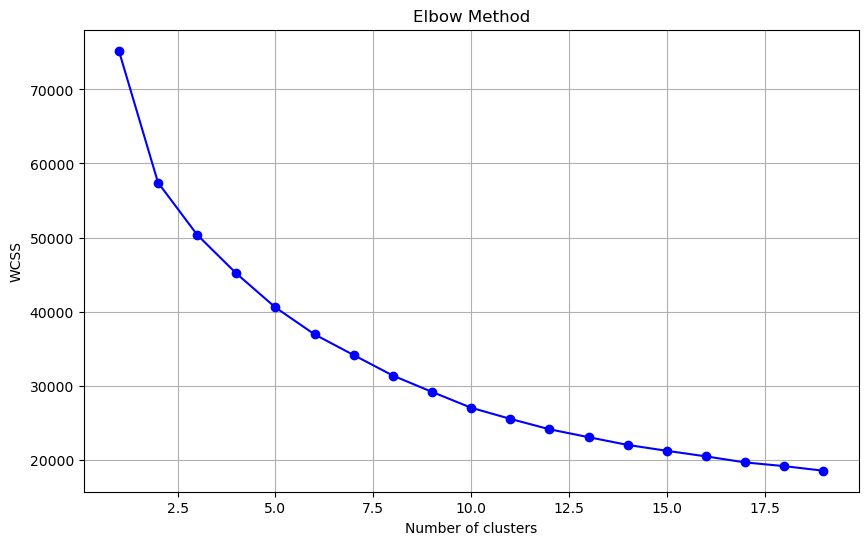

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), wcss,  marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [57]:
optimal_clusters = 10 # becuase it seems the one that fits
model = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)


In [58]:
# Fit the model on the training data
y_pred = model.fit_predict(scaled_features)

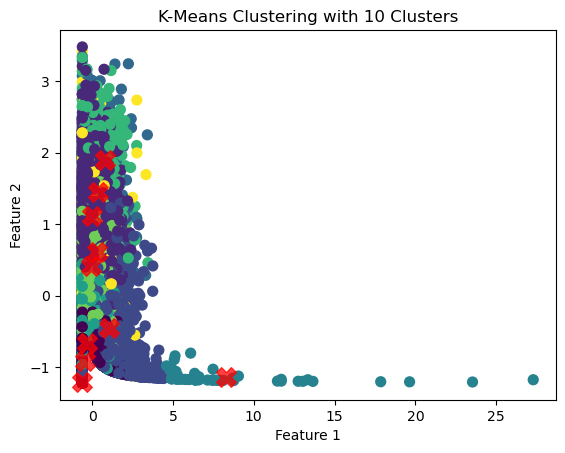

In [59]:
# Plotting the clusters with optimal number
plt.scatter(scaled_features[:, 2], scaled_features[:, 3], c=y_pred, s=50, cmap='viridis')

centers = model.cluster_centers_
plt.scatter(centers[:, 2], centers[:, 3], c='red', s=200, alpha=0.75, marker='X')
plt.title(f'K-Means Clustering with {optimal_clusters} Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [61]:

df['kmeans'] = y_pred

In [ ]:
sns.scatterplot(data = df , df = 'Year', y = 'Engine_Size', hue = 'kmeans')
